In [1]:
import os
import random
import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset

import numpy as np 
import pickle
import matplotlib.pyplot as plt
import time
import copy

from sklearn.model_selection import train_test_split
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

random_seed = 1
random.seed(random_seed)
np.random.seed(random_seed)

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/fcn')

In [2]:
X = pickle.load(open('../dataset/train/cross_subject_data_5_subjects.pickle', 'rb'))
y = X['train_y']

X = X['train_x'].astype(np.float32)

label_map = {'imagine_both_feet': 0, 'imagine_both_fist': 1, 'imagine_left_fist': 2, 'imagine_right_fist': 3}
y = np.vectorize(label_map.__getitem__)(y)

# Convert data to [n_samples, n_channels] -> [n_samples, seq_len, n_channels]

In [3]:
seq_len = 100
n_channels = 64

def reshape_data_cnn(X, y, seq_len):
    print('X original shape:', X.shape)
    print('y original shape:', y.shape)
    len_tail = X.shape[0] % seq_len
    X = X[:-len_tail].reshape(-1, 1, seq_len, n_channels)
    X = np.moveaxis(X, 2, -1)
    y = y[:-len_tail].reshape(-1, seq_len)
    y = y[:, -1]
    print('X conversion shape:', X.shape)
    print('y conversion shape:', y.shape)
    return X, y

X, y = reshape_data_cnn(X, y, seq_len)

X original shape: (295008, 64)
y original shape: (295008,)
X conversion shape: (2950, 1, 64, 100)
y conversion shape: (2950,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)
def print_class_dist(y):
    dist = {}

    labels = np.unique(y)
    for label in labels:
        dist[str(label)] = len(y[y == label]) / len(y)
    print(dist)
print_class_dist(y)
print_class_dist(y_train)
print_class_dist(y_test)

{'0': 0.24745762711864408, '1': 0.25254237288135595, '2': 0.25864406779661014, '3': 0.24135593220338983}
{'0': 0.24745762711864408, '1': 0.25254237288135595, '2': 0.2584745762711864, '3': 0.24152542372881355}
{'0': 0.24745762711864408, '1': 0.25254237288135595, '2': 0.2593220338983051, '3': 0.24067796610169492}


In [5]:
# Normalize
mean, std = X.mean(), X.std()
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [6]:
batch_size = 100
X_train, y_train = torch.tensor(X_train).to(device), torch.tensor(y_train).to(device)
X_test, y_test = torch.tensor(X_test).to(device), torch.tensor(y_test).to(device)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

dataset_sizes = {'train': len(train_dataset), 'val': len(test_dataset)}
dataloaders = {'train': train_loader, 'val': test_loader}
class_names = list(label_map.keys())
print(class_names)

['imagine_both_feet', 'imagine_both_fist', 'imagine_left_fist', 'imagine_right_fist']


In [7]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            writer.add_scalar(f'{phase} loss', epoch_loss, epoch)
            writer.add_scalar(f'{phase} accuracy', epoch_acc, epoch)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model

In [8]:
input_height = 64
input_width = 100
kernel_size = 32
num_layers = 2
num_classes = 4
num_epochs = 100
batch_size = 100

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(input_height, input_height))
        self.relu1 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1184, 512)
        self.fc2 = nn.Linear(512, 4)
        

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

writer.add_graph(model, X_train)

In [9]:
model = train_model(model, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/99
----------
train Loss: 2.2795 Acc: 0.2678
val Loss: 1.9336 Acc: 0.2729

Epoch 1/99
----------
train Loss: 1.5717 Acc: 0.2873
val Loss: 1.6860 Acc: 0.2610

Epoch 2/99
----------
train Loss: 1.4535 Acc: 0.2873
val Loss: 1.4135 Acc: 0.2508

Epoch 3/99
----------
train Loss: 1.4022 Acc: 0.3254
val Loss: 1.4510 Acc: 0.2712

Epoch 4/99
----------
train Loss: 1.4039 Acc: 0.3072
val Loss: 1.4231 Acc: 0.2678

Epoch 5/99
----------
train Loss: 1.3667 Acc: 0.3513
val Loss: 1.5693 Acc: 0.2508

Epoch 6/99
----------
train Loss: 1.3605 Acc: 0.3610
val Loss: 1.4258 Acc: 0.2508

Epoch 7/99
----------
train Loss: 1.3338 Acc: 0.3856
val Loss: 1.4639 Acc: 0.2288

Epoch 8/99
----------
train Loss: 1.3078 Acc: 0.3911
val Loss: 1.4569 Acc: 0.2322

Epoch 9/99
----------
train Loss: 1.3200 Acc: 0.3945
val Loss: 1.4676 Acc: 0.2322

Epoch 10/99
----------
train Loss: 1.3083 Acc: 0.4153
val Loss: 1.4798 Acc: 0.2729

Epoch 11/99
----------
train Loss: 1.3166 Acc: 0.4085
val Loss: 1.4787 Acc: 0.2814

Ep

In [10]:
_, y_pred = torch.max(model(X_test), 1)

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
cr = classification_report(y_test.cpu().numpy(), y_pred.cpu().numpy())
print(cr)

cm = confusion_matrix(y_test.cpu().numpy(), y_pred.cpu().numpy())
print(cm)

y_pred_ohe = np.zeros((y_pred.size(0), num_classes))
for i, j in enumerate(y_pred):
    y_pred_ohe[i, j] = 1

y_test_ohe = np.zeros((y_test.size(0), num_classes))
for i, j in enumerate(y_test):
    y_test_ohe[i, j] = 1
auroc = roc_auc_score(y_test_ohe, y_pred_ohe, multi_class='ovo')
writer.add_scalar('AUROC OvO', auroc)
print('AUROC ovo:', auroc)
auroc = roc_auc_score(y_test_ohe, y_pred_ohe, multi_class='ovr')
writer.add_scalar('AUROC OvR', auroc)
print('AUROC ovr:', auroc)

              precision    recall  f1-score   support

           0       0.30      0.30      0.30       146
           1       0.29      0.53      0.37       149
           2       0.24      0.10      0.14       153
           3       0.29      0.22      0.25       142

    accuracy                           0.29       590
   macro avg       0.28      0.29      0.27       590
weighted avg       0.28      0.29      0.26       590

[[44 61 15 26]
 [33 79 15 22]
 [33 77 15 28]
 [36 57 18 31]]
AUROC ovo: 0.5245663756977821
AUROC ovr: 0.5245663756977821


In [12]:
{str(v): k for k, v in label_map.items()}

{'0': 'imagine_both_feet',
 '1': 'imagine_both_fist',
 '2': 'imagine_left_fist',
 '3': 'imagine_right_fist'}

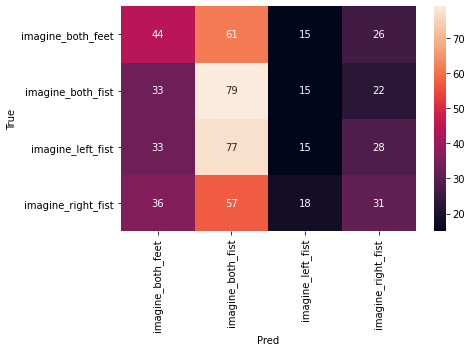

In [13]:
import seaborn as sns
import pandas as pd
import io

figure = plt.figure(figsize=(7, 5))
cm_df = pd.DataFrame(cm, columns=class_names, index=class_names)
sns.heatmap(cm_df, annot=True, fmt='g')
plt.ylabel('True')
plt.xlabel('Pred')
plt.tight_layout()
plt.savefig('runs/fcn/cm.png')
plt.show()

In [14]:
print('Number of trainable parameters')
sum(p.numel() for p in model.parameters() if p.requires_grad)

Number of trainable parameters


739876